In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sa

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [2]:
from keras.models import load_model

model_view = load_model('../model/saved/d-view.keras')
model_cart = load_model('../model/saved/d-cart.keras')
model_remove_from_cart = load_model('../model/saved/d-remove_from_cart.keras')
model_purchase = load_model('../model/saved/d-purchase.keras')

In [3]:
conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [4]:
def df_to_X_y(df: pd.DataFrame):
    df_as_np = df.to_numpy()
    X = df_as_np[:, 6:]
    y = df_as_np[:, 2:6]
    return X, y


In [7]:
from collections import defaultdict
import datetime
from sqlalchemy import orm

from schemas.product import Product
from schemas.data_by_date import DataByDate

prev_days = int(os.getenv('PREV_DAYS'))

with orm.Session(engine) as session, session.begin():
    products = dict[tuple[int, int], Product]()
    for row in session.scalars(sa.select(Product)).all():
        products[(row.product_id, row.category_id)] = row
    
    memorized = defaultdict(lambda: defaultdict(lambda: { 'view': 0, 'cart': 0, 'remove_from_cart': 0, 'purchase': 0 }))

    d = datetime.date(2020, 2, 15) - datetime.timedelta(days=prev_days)
    for i in range(prev_days):
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            memorized[d][key] = {
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
            }

        d += datetime.timedelta(days=1)
    
    end = datetime.date(2020, 3, 1)
    while d < end:        
        records = list[dict[str, int]]()
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            record = {
                'product_id': row.product_id,
                'category_id': row.category_id,
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
                'rank': row.rank,
                'rank_in_category': row.rank_in_category,
                'days_on_shelf': (d - products[key].release_date).days,
                'price': row.max_price,
            }

            for i in range(1, prev_days + 1):
                prev_d = d - datetime.timedelta(days=i)
                record[f'view_prev{i}'] = memorized[prev_d][key]['view']
                record[f'cart_prev{i}'] = memorized[prev_d][key]['cart']
                record[f'remove_from_cart_prev{i}'] = memorized[prev_d][key]['remove_from_cart']
                record[f'purchase_prev{i}'] = memorized[prev_d][key]['purchase']

            release_date = products[key].release_date
            if (d - products[key].release_date).days >= 7:
                records.append(record)
        
        del memorized[d - datetime.timedelta(days=prev_days)]

        df = pd.DataFrame.from_records(records)
        X, y = df_to_X_y(df)
        df['predicted_view'] = model_view.predict(X)[:, 0]
        df['predicted_cart'] = model_cart.predict(X)[:, 0]
        df['predicted_remove_from_cart'] = model_remove_from_cart.predict(X)[:, 0]
        df['predicted_purchase'] = model_purchase.predict(X)[:, 0]

        result_df = df[[
            'product_id', 
            'category_id', 
            'view', 
            'predicted_view', 
            'cart', 
            'predicted_cart', 
            'remove_from_cart', 
            'predicted_remove_from_cart', 
            'purchase', 
            'predicted_purchase'
        ]]
        name = d.strftime('%Y-%m-%d')
        result_df.to_csv(f'../.data/predict/d-{name}.csv')
        results = result_df.to_dict('records')
        for result in results:
            key = (result['product_id'], result['category_id'])
            memorized[d][key] = {
                'view': result['predicted_view'],
                'cart': result['predicted_cart'],
                'remove_from_cart': result['predicted_remove_from_cart'],
                'purchase': result['predicted_purchase'],
            }

        d += datetime.timedelta(days=1)
        
        

700/700 [==============================] - 1s 2ms/step


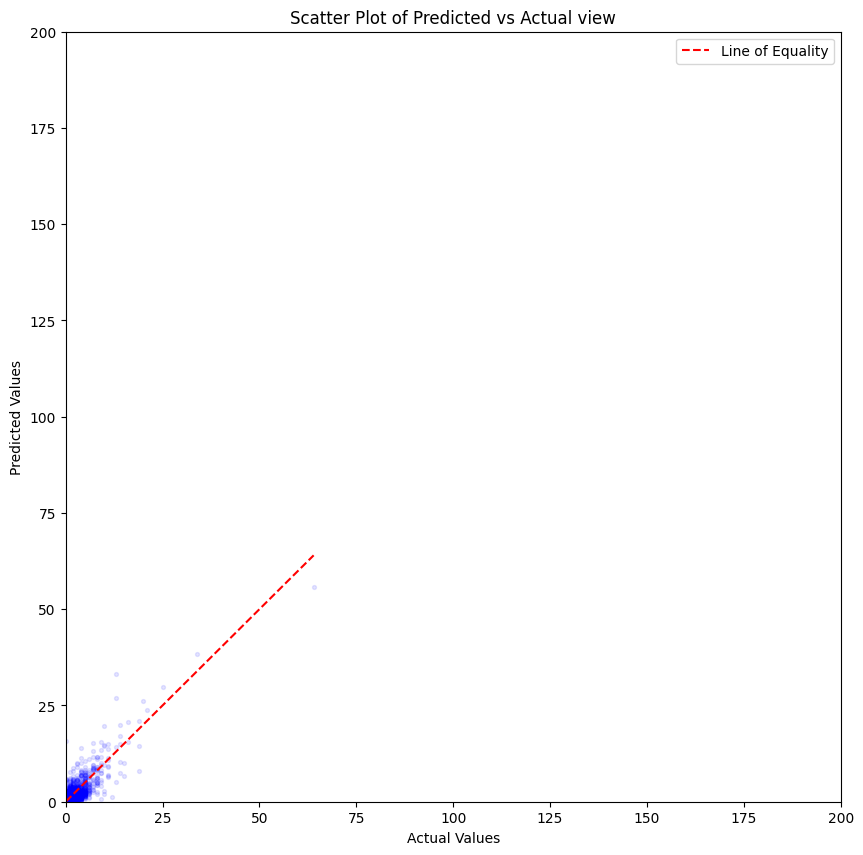

,Unnamed: 0,product_id,category_id,view,predicted_view,cart,predicted_cart,remove_from_cart,predicted_remove_from_cart,purchase,predicted_purchase
0,0,5809910,1602943681873052386,584,661.230000,214,171.997880,102,116.965850,64,55.840008
1,1,5854897,1487580009445982239,51,56.328610,186,229.029600,55,69.459200,34,38.331753
2,2,5809912,1602943681873052386,178,216.891170,93,104.826220,65,77.778310,20,26.176977
3,3,5700037,1487580009286598681,71,89.193245,125,262.254240,52,73.212105,13,33.241210
4,4,5751422,1487580005268456287,129,105.944420,80,65.522530,48,47.103596,19,21.046644
...,...,...,...,...,...,...,...,...,...,...,...
22335,22335,5927831,1487580007675986893,1,1.429327,1,0.465754,0,0.599954,0,0.174154
22336,22336,5927836,1487580007675986893,1,1.145447,3,0.468243,2,0.612383,0,0.172894
22337,22337,5927840,1487580007675986893,0,1.316577,1,0.542078,0,0.520850,1,0.174537
22338,22338,5927841,1487580007675986893,1,1.306485,1,0.489262,2,0.498756,0,0.162003


In [21]:
from training.utils import plot_accuracy

result_df = pd.read_csv('../.data/predict/d-2020-02-18.csv')

plot_accuracy(result_df['predicted_purchase'], result_df['purchase'], 'view', (0, 200))
result_df